# **Imports**

In [1]:
pip install keras-cv --upgrade

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Common
import os
import keras
import numpy as np
from tqdm import tqdm
from glob import glob
import tensorflow as tf
import cv2 as cv
# Data 
from keras.utils import img_to_array, array_to_img

# Data Viz
import matplotlib.pyplot as plt

# Model 
from keras import Sequential
from keras.layers import Conv2D, Conv2DTranspose, InputLayer, Layer, Input, Dropout, MaxPool2D, concatenate
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

# **Data**

In [4]:
# input data of training data
path = './cityscapes-image-pairs/cityscapes_data/train/'
image_paths = sorted(glob(path + "*.jpg"))
SIZE = 160
images = np.zeros(shape=(len(image_paths), SIZE, SIZE, 3))
masks = np.zeros(shape=(len(image_paths), SIZE, SIZE, 3))

for i in tqdm(range(len(image_paths))):
    path = image_paths[i]
    image = cv.imread(path)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    image = img_to_array(image).astype('float')
    img = image[:,:256,:]/255.0
    img = tf.image.resize(img,(SIZE, SIZE))
    mask = image[:,256:,:]/255.0
    mask = tf.image.resize(mask,(SIZE, SIZE))
    images[i] = img
    masks[i] = mask

100%|██████████| 2975/2975 [00:46<00:00, 63.36it/s]


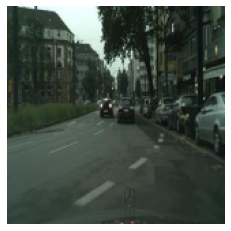

In [5]:
plt.imshow(images[45])
plt.axis('off')
plt.show()

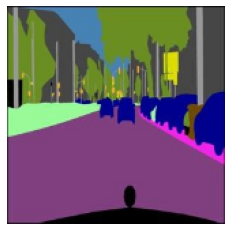

In [6]:
plt.imshow(masks[45])
plt.axis('off')
plt.show()

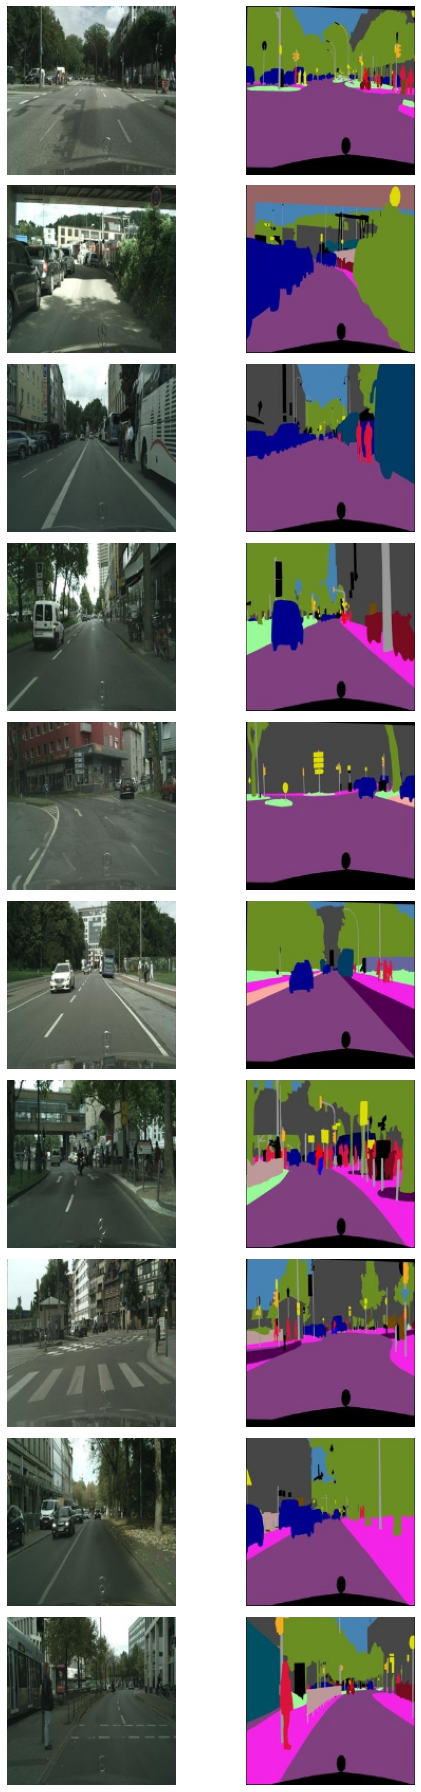

In [7]:
plt.figure(figsize=(8,25))
for i in range(1,21):
  plt.subplot(10,2,i)
  if i%2!=0:
    id = np.random.randint(len(images))
    image = images[id]
    plt.imshow(image)
    plt.axis('off')
  elif i%2==0:
    mask = masks[id]
    plt.imshow(mask)
    plt.axis('off')  
plt.tight_layout()
plt.show()

In [8]:
X_train, y_train = images[:2900], masks[:2900]
X_valid, y_valid = images[2900:], masks[2900:]

# **UNet Autoencoder**

In [9]:
# Encoder Layer Block
class EncoderLayerBlock(Layer):
  def __init__(self, filters, rate, pooling=True):
    super(EncoderLayerBlock, self).__init__()
    self.filters = filters
    self.rate = rate
    self.pooling = pooling

    self.c1 = Conv2D(self.filters, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')
    self.drop = Dropout(self.rate)
    self.c2 = Conv2D(self.filters, kernel_size=3, padding='same', activation='relu', kernel_initializer='he_normal')
    self.pool = MaxPool2D(pool_size=(2,2))

  def call(self, X):
    x = self.c1(X)
    x = self.drop(x)
    x = self.c2(x)
    if self.pooling:
      y = self.pool(x)
      return y, x
    else: 
      return x

  def get_config(self):
    base_estimator = super().get_config()
    return {
        **base_estimator,
        "filters":self.filters,
        "rate":self.rate,
        "pooling":self.pooling
    }

#  Decoder Layer
class DecoderLayerBlock(Layer):
  def __init__(self, filters, rate, padding='same'):
    super(DecoderLayerBlock, self).__init__()
    self.filters = filters
    self.rate = rate
    self.cT = Conv2DTranspose(self.filters, kernel_size=3, strides=2, padding=padding)
    self.next = EncoderLayerBlock(self.filters, self.rate, pooling=False)

  def call(self, X):
    X, skip_X = X
    x = self.cT(X)
    c1 = concatenate([x, skip_X])
    y = self.next(c1)
    return y 

  def get_config(self):
    base_estimator = super().get_config()
    return {
        **base_estimator,
        "filters":self.filters,
        "rate":self.rate,
    }

#  Callback 
class ShowProgress(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    id = np.random.randint(len(X_valid))
    rand_img = X_valid[id][np.newaxis,...]
    pred_mask = self.model.predict(rand_img)[0]
    true_mask = y_valid[id]

    
    plt.subplot(1,3,1)
    plt.imshow(rand_img[0])
    plt.title("Original Image")
    plt.axis('off')
    

    plt.subplot(1,3,2)
    plt.imshow(pred_mask)
    plt.title("Predicted Mask")
    plt.axis('off')
    
    plt.subplot(1,3,3)
    plt.imshow(true_mask)
    plt.title("True Mask")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

Epoch 1/50
1/1 [==============================] - 1s 788ms/steposs: 0.6388 - accuracy: 0.4132 - mean_io_u: 0.50


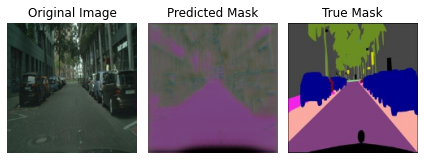

91/91 [==============================] - 452s 5s/step - loss: 0.6388 - accuracy: 0.4132 - mean_io_u: 0.5000 - val_loss: 0.6237 - val_accuracy: 0.3918 - val_mean_io_u: 0.5000
Epoch 2/50
1/1 [==============================] - 0s 94ms/steploss: 0.6017 - accuracy: 0.4432 - mean_io_u: 0.50


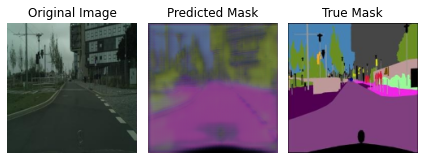

91/91 [==============================] - 395s 4s/step - loss: 0.6017 - accuracy: 0.4432 - mean_io_u: 0.5000 - val_loss: 0.6079 - val_accuracy: 0.5700 - val_mean_io_u: 0.5000
Epoch 3/50
1/1 [==============================] - 0s 50ms/steploss: 0.5882 - accuracy: 0.5517 - mean_io_u: 0.50


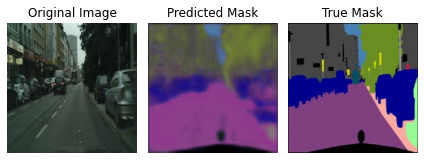

91/91 [==============================] - 272s 3s/step - loss: 0.5882 - accuracy: 0.5517 - mean_io_u: 0.5000 - val_loss: 0.5952 - val_accuracy: 0.6452 - val_mean_io_u: 0.5000
Epoch 4/50
1/1 [==============================] - 0s 64ms/steploss: 0.5828 - accuracy: 0.5730 - mean_io_u: 0.50


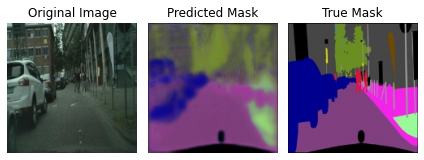

91/91 [==============================] - 305s 3s/step - loss: 0.5828 - accuracy: 0.5730 - mean_io_u: 0.5000 - val_loss: 0.5903 - val_accuracy: 0.6553 - val_mean_io_u: 0.5000
Epoch 5/50
1/1 [==============================] - 0s 50ms/steploss: 0.5767 - accuracy: 0.6074 - mean_io_u: 0.50


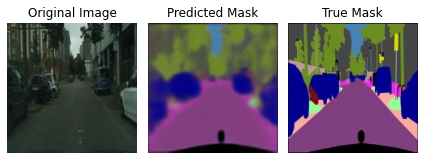

91/91 [==============================] - 316s 3s/step - loss: 0.5767 - accuracy: 0.6074 - mean_io_u: 0.5000 - val_loss: 0.5847 - val_accuracy: 0.6654 - val_mean_io_u: 0.5000
Epoch 6/50
1/1 [==============================] - 0s 79ms/steploss: 0.5733 - accuracy: 0.6257 - mean_io_u: 0.50


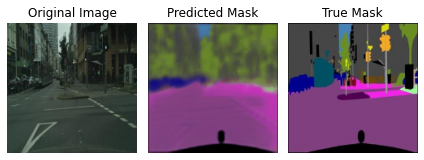

91/91 [==============================] - 307s 3s/step - loss: 0.5733 - accuracy: 0.6257 - mean_io_u: 0.5000 - val_loss: 0.5840 - val_accuracy: 0.6756 - val_mean_io_u: 0.5000
Epoch 7/50
1/1 [==============================] - 0s 98ms/steploss: 0.5707 - accuracy: 0.6370 - mean_io_u: 0.50


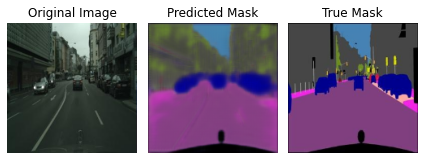

91/91 [==============================] - 305s 3s/step - loss: 0.5707 - accuracy: 0.6370 - mean_io_u: 0.5000 - val_loss: 0.5815 - val_accuracy: 0.6892 - val_mean_io_u: 0.5000
Epoch 8/50
1/1 [==============================] - 0s 78ms/steploss: 0.5688 - accuracy: 0.6481 - mean_io_u: 0.50


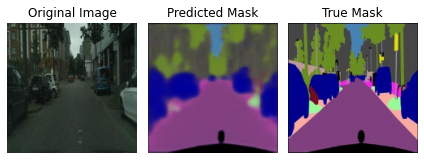

91/91 [==============================] - 307s 3s/step - loss: 0.5688 - accuracy: 0.6481 - mean_io_u: 0.5000 - val_loss: 0.5797 - val_accuracy: 0.7065 - val_mean_io_u: 0.5000
Epoch 9/50
1/1 [==============================] - 0s 85ms/steploss: 0.5667 - accuracy: 0.6512 - mean_io_u: 0.50


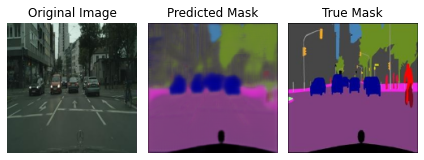

91/91 [==============================] - 312s 3s/step - loss: 0.5667 - accuracy: 0.6512 - mean_io_u: 0.5000 - val_loss: 0.5787 - val_accuracy: 0.6966 - val_mean_io_u: 0.5000
Epoch 10/50
1/1 [==============================] - 0s 104ms/steposs: 0.5655 - accuracy: 0.6565 - mean_io_u: 0.50


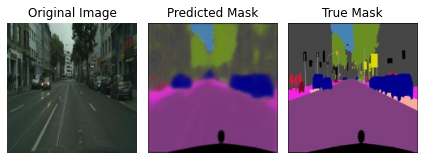

91/91 [==============================] - 318s 3s/step - loss: 0.5655 - accuracy: 0.6565 - mean_io_u: 0.5000 - val_loss: 0.5781 - val_accuracy: 0.6521 - val_mean_io_u: 0.5000
Epoch 11/50
1/1 [==============================] - 0s 59ms/steploss: 0.5639 - accuracy: 0.6631 - mean_io_u: 0.50


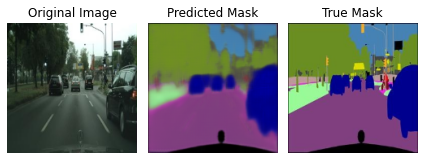

91/91 [==============================] - 324s 4s/step - loss: 0.5639 - accuracy: 0.6631 - mean_io_u: 0.5000 - val_loss: 0.5769 - val_accuracy: 0.7281 - val_mean_io_u: 0.5000
Epoch 12/50
1/1 [==============================] - 0s 59ms/steploss: 0.5632 - accuracy: 0.6683 - mean_io_u: 0.50


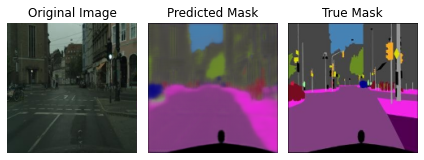

91/91 [==============================] - 319s 4s/step - loss: 0.5632 - accuracy: 0.6683 - mean_io_u: 0.5000 - val_loss: 0.5770 - val_accuracy: 0.7368 - val_mean_io_u: 0.5000
Epoch 13/50
1/1 [==============================] - 0s 48ms/steploss: 0.5619 - accuracy: 0.6743 - mean_io_u: 0.50


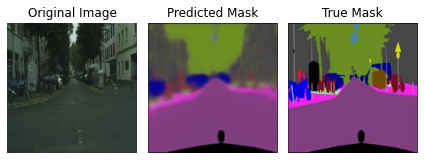

91/91 [==============================] - 323s 4s/step - loss: 0.5619 - accuracy: 0.6743 - mean_io_u: 0.5000 - val_loss: 0.5764 - val_accuracy: 0.7553 - val_mean_io_u: 0.5000
Epoch 14/50
1/1 [==============================] - 0s 78ms/steploss: 0.5608 - accuracy: 0.6818 - mean_io_u: 0.50


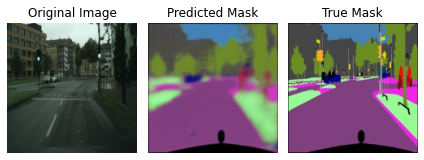

91/91 [==============================] - 309s 3s/step - loss: 0.5608 - accuracy: 0.6818 - mean_io_u: 0.5000 - val_loss: 0.5754 - val_accuracy: 0.7572 - val_mean_io_u: 0.5000
Epoch 15/50
1/1 [==============================] - 0s 67ms/steploss: 0.5605 - accuracy: 0.6822 - mean_io_u: 0.50


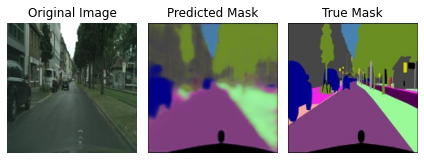

91/91 [==============================] - 305s 3s/step - loss: 0.5605 - accuracy: 0.6822 - mean_io_u: 0.5000 - val_loss: 0.5759 - val_accuracy: 0.7474 - val_mean_io_u: 0.5000
Epoch 16/50
1/1 [==============================] - 0s 56ms/steploss: 0.5596 - accuracy: 0.6822 - mean_io_u: 0.50


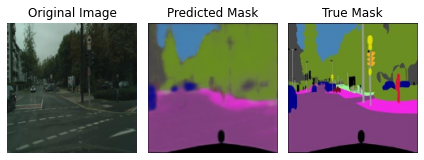

91/91 [==============================] - 317s 3s/step - loss: 0.5596 - accuracy: 0.6822 - mean_io_u: 0.5000 - val_loss: 0.5758 - val_accuracy: 0.7556 - val_mean_io_u: 0.5000
Epoch 17/50
1/1 [==============================] - 0s 67ms/steploss: 0.5593 - accuracy: 0.6844 - mean_io_u: 0.50


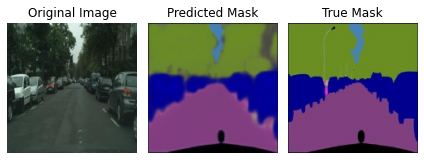

91/91 [==============================] - 324s 4s/step - loss: 0.5593 - accuracy: 0.6844 - mean_io_u: 0.5000 - val_loss: 0.5747 - val_accuracy: 0.7325 - val_mean_io_u: 0.5000
Epoch 18/50
1/1 [==============================] - 0s 71ms/steploss: 0.5583 - accuracy: 0.6900 - mean_io_u: 0.50


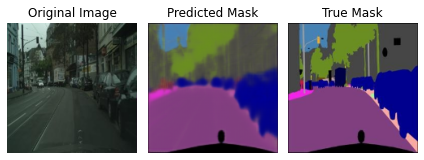

91/91 [==============================] - 322s 4s/step - loss: 0.5583 - accuracy: 0.6900 - mean_io_u: 0.5000 - val_loss: 0.5752 - val_accuracy: 0.7438 - val_mean_io_u: 0.5000
Epoch 19/50
1/1 [==============================] - 0s 78ms/steploss: 0.5583 - accuracy: 0.6879 - mean_io_u: 0.50


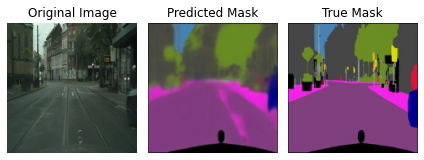

91/91 [==============================] - 321s 4s/step - loss: 0.5583 - accuracy: 0.6879 - mean_io_u: 0.5000 - val_loss: 0.5747 - val_accuracy: 0.7161 - val_mean_io_u: 0.5000
Epoch 20/50
1/1 [==============================] - 0s 62ms/steploss: 0.5577 - accuracy: 0.6879 - mean_io_u: 0.50


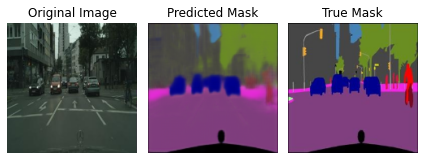

91/91 [==============================] - 312s 3s/step - loss: 0.5577 - accuracy: 0.6879 - mean_io_u: 0.5000 - val_loss: 0.5735 - val_accuracy: 0.7591 - val_mean_io_u: 0.5000
Epoch 21/50
1/1 [==============================] - 0s 42ms/steploss: 0.5571 - accuracy: 0.6935 - mean_io_u: 0.50


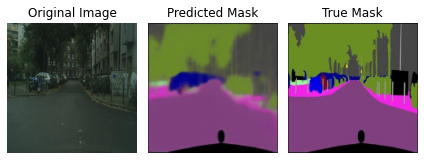

91/91 [==============================] - 314s 3s/step - loss: 0.5571 - accuracy: 0.6935 - mean_io_u: 0.5000 - val_loss: 0.5738 - val_accuracy: 0.7277 - val_mean_io_u: 0.5000
Epoch 22/50
1/1 [==============================] - 0s 46ms/steploss: 0.5572 - accuracy: 0.6906 - mean_io_u: 0.50


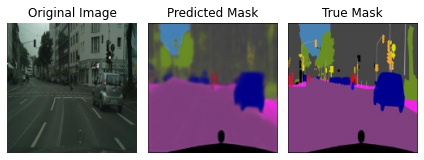

91/91 [==============================] - 314s 3s/step - loss: 0.5572 - accuracy: 0.6906 - mean_io_u: 0.5000 - val_loss: 0.5734 - val_accuracy: 0.7435 - val_mean_io_u: 0.5000
Epoch 23/50
1/1 [==============================] - 0s 40ms/steploss: 0.5562 - accuracy: 0.6869 - mean_io_u: 0.50


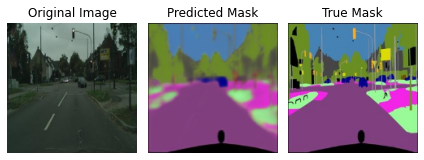

91/91 [==============================] - 626s 7s/step - loss: 0.5562 - accuracy: 0.6869 - mean_io_u: 0.5000 - val_loss: 0.5739 - val_accuracy: 0.7776 - val_mean_io_u: 0.5000
Epoch 24/50
1/1 [==============================] - 0s 47ms/steploss: 0.5560 - accuracy: 0.6922 - mean_io_u: 0.50


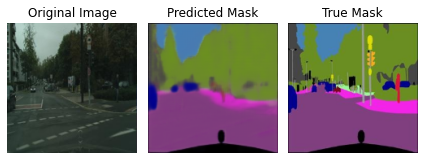

91/91 [==============================] - 300s 3s/step - loss: 0.5560 - accuracy: 0.6922 - mean_io_u: 0.5000 - val_loss: 0.5729 - val_accuracy: 0.7564 - val_mean_io_u: 0.5000
Epoch 25/50
1/1 [==============================] - 0s 46ms/steploss: 0.5554 - accuracy: 0.6927 - mean_io_u: 0.50


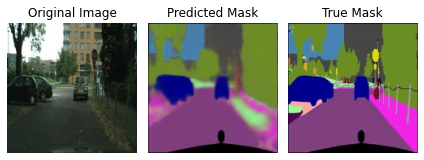

91/91 [==============================] - 291s 3s/step - loss: 0.5554 - accuracy: 0.6927 - mean_io_u: 0.5000 - val_loss: 0.5727 - val_accuracy: 0.7538 - val_mean_io_u: 0.5000
Epoch 26/50
1/1 [==============================] - 0s 38ms/steploss: 0.5549 - accuracy: 0.6867 - mean_io_u: 0.50


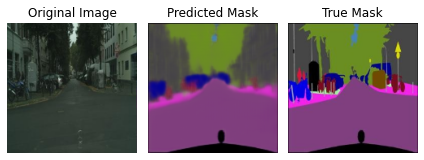

91/91 [==============================] - 289s 3s/step - loss: 0.5549 - accuracy: 0.6867 - mean_io_u: 0.5000 - val_loss: 0.5733 - val_accuracy: 0.7650 - val_mean_io_u: 0.5000
Epoch 27/50
1/1 [==============================] - 0s 42ms/steploss: 0.5545 - accuracy: 0.6914 - mean_io_u: 0.50


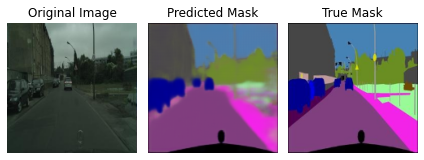

91/91 [==============================] - 298s 3s/step - loss: 0.5545 - accuracy: 0.6914 - mean_io_u: 0.5000 - val_loss: 0.5725 - val_accuracy: 0.7667 - val_mean_io_u: 0.5000
Epoch 28/50
1/1 [==============================] - 0s 51ms/steploss: 0.5541 - accuracy: 0.6925 - mean_io_u: 0.50


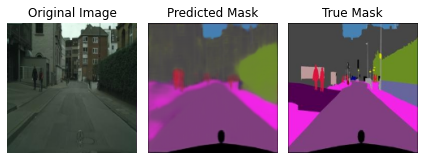

91/91 [==============================] - 300s 3s/step - loss: 0.5541 - accuracy: 0.6925 - mean_io_u: 0.5000 - val_loss: 0.5731 - val_accuracy: 0.7763 - val_mean_io_u: 0.5000
Epoch 29/50
1/1 [==============================] - 0s 70ms/steploss: 0.5547 - accuracy: 0.6886 - mean_io_u: 0.50


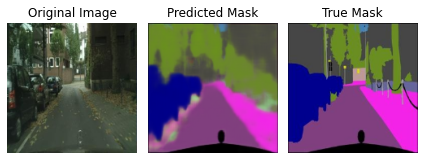

91/91 [==============================] - 308s 3s/step - loss: 0.5547 - accuracy: 0.6886 - mean_io_u: 0.5000 - val_loss: 0.5739 - val_accuracy: 0.7248 - val_mean_io_u: 0.5000
Epoch 30/50
1/1 [==============================] - 0s 51ms/steploss: 0.5538 - accuracy: 0.6954 - mean_io_u: 0.50


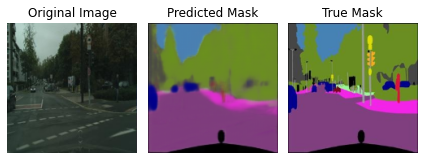

91/91 [==============================] - 324s 4s/step - loss: 0.5538 - accuracy: 0.6954 - mean_io_u: 0.5000 - val_loss: 0.5730 - val_accuracy: 0.7431 - val_mean_io_u: 0.5000
Epoch 31/50
1/1 [==============================] - 0s 47ms/steploss: 0.5540 - accuracy: 0.6965 - mean_io_u: 0.50


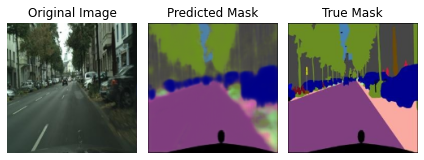

91/91 [==============================] - 326s 4s/step - loss: 0.5540 - accuracy: 0.6965 - mean_io_u: 0.5000 - val_loss: 0.5726 - val_accuracy: 0.7540 - val_mean_io_u: 0.5000
Epoch 32/50
1/1 [==============================] - 0s 51ms/steploss: 0.5533 - accuracy: 0.6977 - mean_io_u: 0.50


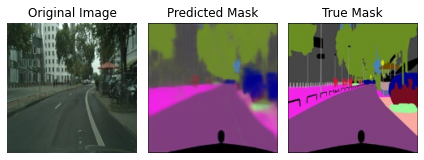

91/91 [==============================] - 305s 3s/step - loss: 0.5533 - accuracy: 0.6977 - mean_io_u: 0.5000 - val_loss: 0.5728 - val_accuracy: 0.7448 - val_mean_io_u: 0.5000


In [10]:
with tf.device('/GPU:0'):
    # Input Layer 
    input_layer = Input(shape=X_train.shape[-3:])

    # Encoder
    p1, c1 = EncoderLayerBlock(16,0.1)(input_layer)
    p2, c2 = EncoderLayerBlock(32,0.1)(p1)
    p3, c3 = EncoderLayerBlock(64,0.2)(p2)
    p4, c4 = EncoderLayerBlock(128,0.2)(p3)

    # Encoding Layer
    c5 = EncoderLayerBlock(256,0.3,pooling=False)(p4)

    # Decoder
    d1 = DecoderLayerBlock(128,0.2)([c5, c4])
    d2 = DecoderLayerBlock(64,0.2)([d1, c3])
    d3 = DecoderLayerBlock(32,0.2)([d2, c2])
    d4 = DecoderLayerBlock(16,0.2)([d3, c1])

    # Output layer
    output = Conv2D(3,kernel_size=1,strides=1,padding='same',activation='sigmoid')(d4)

    # U-Net Model
    model = keras.models.Model(
        inputs=[input_layer],
        outputs=[output],
    )

    # Compiling
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=0.001),
        metrics=['accuracy', keras.metrics.MeanIoU(num_classes=2)]
    )

    # Callbacks 
    callbacks =[
        EarlyStopping(patience=5, restore_best_weights=True),
        ModelCheckpoint("UNet-Colorizer.h5", save_best_only=True),
        ShowProgress()
    ]

    # Train The Model
    model.fit(
        X_train, y_train,
        validation_data=(X_valid, y_valid),
        epochs=50,
        callbacks=callbacks
    )

# **Evaluation**

In [14]:
path = './cityscapes-image-pairs/cityscapes_data/val/'
image_paths = sorted(glob(path + "*.jpg"))
SIZE = 160
images = np.zeros(shape=(len(image_paths), SIZE, SIZE, 3))
masks = np.zeros(shape=(len(image_paths), SIZE, SIZE, 3))

for i in tqdm(range(len(image_paths))):
    path = image_paths[i]
    image = cv.imread(path)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    image = img_to_array(image).astype('float')
    img = image[:,:256,:]/255.0
    img = tf.image.resize(img,(SIZE, SIZE))
    mask = image[:,256:,:]/255.0
    mask = tf.image.resize(mask,(SIZE, SIZE))
    images[i] = img
    masks[i] = mask

100%|██████████| 500/500 [00:04<00:00, 104.74it/s]


In [15]:
def show_image(image,title=None):
    plt.imshow(image)
    if title is not None: plt.title(title)
    plt.axis('off')

1/1 [==============================] - 0s 41ms/step


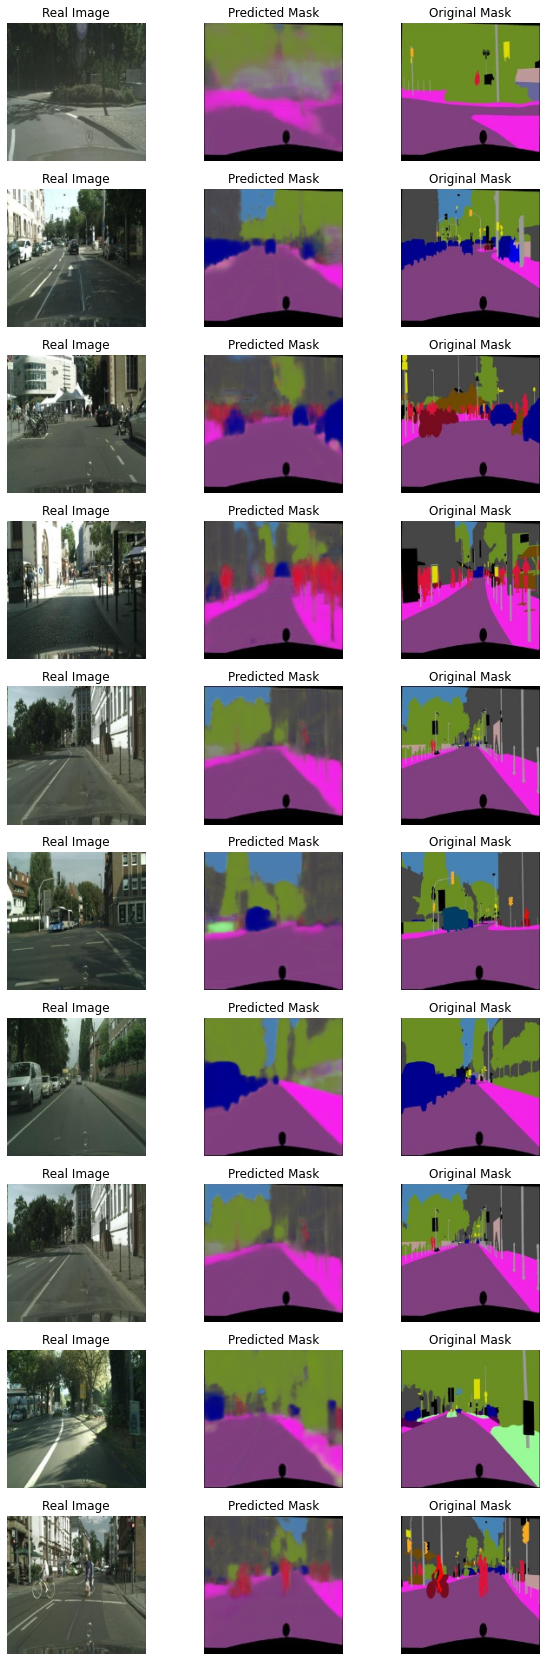

In [16]:
plt.figure(figsize=(10,30))
n=0
for i in range(1,31):
    plt.subplot(10,3,i)
    if n==0:
        id = np.random.randint(len(images))
        real_img = images[id][np.newaxis,...]
        pred_mask = model.predict(real_img)[0]
        mask = masks[id]
        show_image(real_img[0], title="Real Image")
        n+=1
    elif n==1:
        show_image(pred_mask, title="Predicted Mask")
        n+=1
    elif n==2:
        show_image(mask, title="Original Mask")
        n=0
plt.show()

If you ignore the blurriness, you can notice that for almost every image it predicted the right segmentation. And also classified the images correctly based on their pixel levels. You can also see that some of the informations are lost, such as the light pole, etc. Overall the model performed great and if you want even better results used a bigger image input size.

---
Thanks!!!